In [3]:
!pip install s2sphere

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import s2sphere
import matplotlib.patches as patches
from tqdm import tqdm
import os


In [5]:
# --- CONFIGURAZIONE ---
FILE_PATH = "/content/drive/MyDrive/osv5m/train_with_predictions.csv" # Assicurati che il percorso sia corretto

# --- CARICAMENTO DATI E MAPPA ---
print("Caricamento dati per la mappa di densità...")
df = pd.read_csv(FILE_PATH)

Caricamento dati per la mappa di densità...


Caricamento mappa USA...


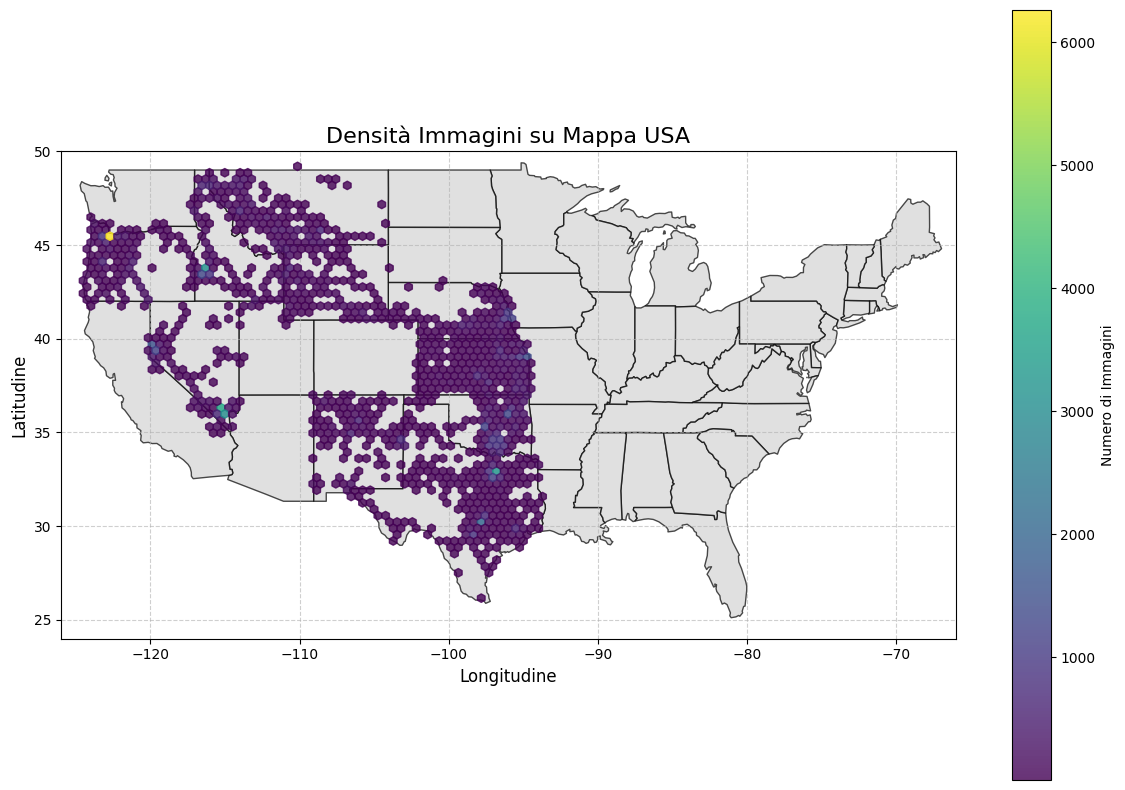


--- Mappa di Densità Completata ---


In [6]:
#Density plot
print("Caricamento mappa USA...")
usa_url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
usa = gpd.read_file(usa_url)
usa = usa[~usa['name'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

# --- PLOT DELLA DENSITÀ SU MAPPA USA ---
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Disegniamo la mappa degli USA come sfondo
usa.plot(ax=ax, color='lightgray', edgecolor='black', zorder=1, alpha=0.7)

# Hexbin per la densità dei punti
hb = ax.hexbin(df['longitude'], df['latitude'], gridsize=60, cmap='viridis', mincnt=1, alpha=0.8, zorder=2)
plt.colorbar(hb, ax=ax, label='Numero di Immagini')

ax.set_title("Densità Immagini su Mappa USA", fontsize=16)
ax.set_xlabel("Longitudine", fontsize=12)
ax.set_ylabel("Latitudine", fontsize=12)
ax.set_xlim([-126, -66]) # Limiti USA continentali
ax.set_ylim([24, 50])
ax.grid(True, linestyle='--', alpha=0.6) # Aggiungiamo una griglia
plt.tight_layout()
plt.show()

print("\n--- Mappa di Densità Completata ---")

🛰️ Caricamento dati e mappa...
🧬 Calcolo S2 Cell IDs iniziali...

🔄 Elaborazione config_1 (K=50, L=14)...
   Celle create: 5672


   Mappatura config_1: 100%|██████████| 119008/119008 [00:01<00:00, 86615.82it/s]



🔄 Elaborazione config_2 (K=100, L=12)...
   Celle create: 2845


   Mappatura config_2: 100%|██████████| 119008/119008 [00:00<00:00, 123908.16it/s]



🔄 Elaborazione config_3 (K=200, L=10)...
   Celle create: 1266


   Mappatura config_3: 100%|██████████| 119008/119008 [00:00<00:00, 169410.00it/s]


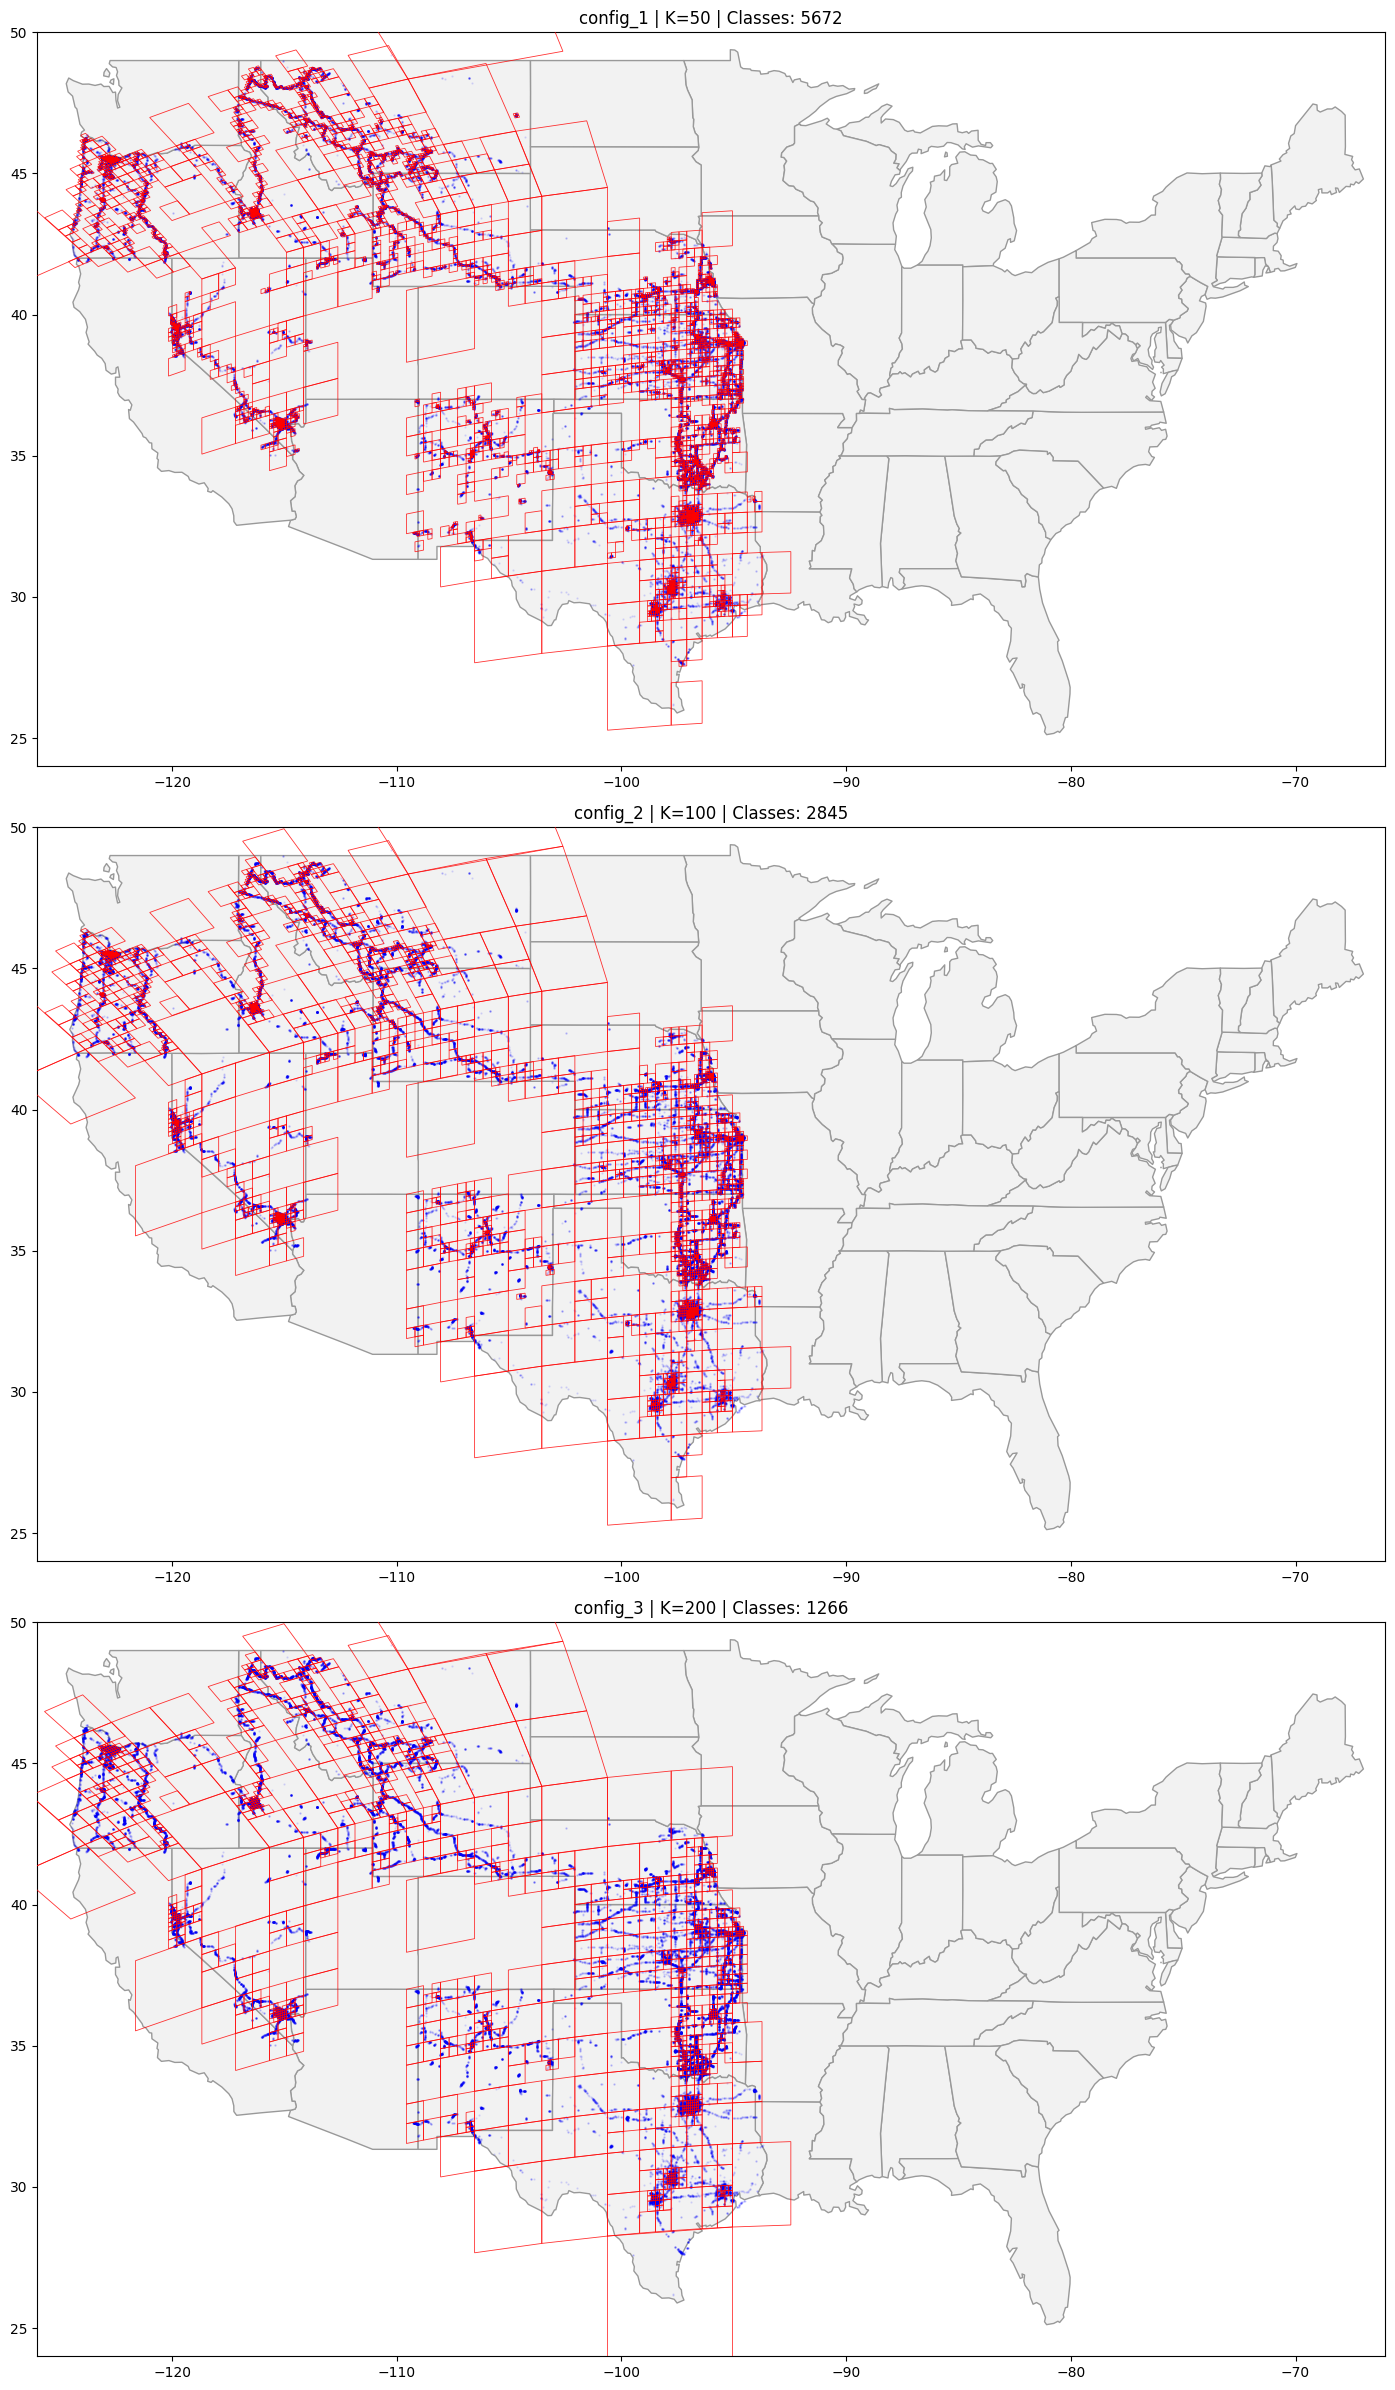


✅ Dataset TRAIN salvato in: /content/drive/MyDrive/osv5m/train_with_labels_3configs.csv

🧪 Calcolo S2 Cell IDs per il Test Set...
   Classificazione rapida Test Set per config_1...


   Matching config_1: 100%|██████████| 10110/10110 [00:00<00:00, 22157.55it/s]


   Classificazione rapida Test Set per config_2...


   Matching config_2: 100%|██████████| 10110/10110 [00:00<00:00, 28568.65it/s]


   Classificazione rapida Test Set per config_3...


   Matching config_3: 100%|██████████| 10110/10110 [00:00<00:00, 43967.05it/s]



✅ Dataset TEST salvato in: /content/drive/MyDrive/osv5m/test_with_target_labels.csv


In [ ]:
# --- 1. CONFIGURAZIONE PERCORSI ---
INPUT_TRAIN = "/content/drive/MyDrive/osv5m/train_with_predictions.csv"
INPUT_TEST = "/content/drive/MyDrive/osv5m/test_with_predictions.csv"
OUTPUT_TRAIN = "/content/drive/MyDrive/osv5m/train_with_labels_3configs.csv"
OUTPUT_TEST = "/content/drive/MyDrive/osv5m/test_with_target_labels.csv"

# --- 2. CONFIGURAZIONI GRID ---
configs = [
    {"name": "config_1", "min_images": 50, "max_level": 14},
    {"name": "config_2", "min_images": 100, "max_level": 12},
    {"name": "config_3", "min_images": 200, "max_level": 10}
]

# --- 3. FUNZIONI DI SUPPORTO ---
def get_s2_cell_id(lat, lng):
    return s2sphere.CellId.from_lat_lng(s2sphere.LatLng.from_degrees(lat, lng))

def get_cell_vertices(cell_id):
    cell = s2sphere.Cell(cell_id)
    vertices = []
    for i in range(4):
        vertex = s2sphere.LatLng.from_point(cell.get_vertex(i))
        vertices.append((vertex.lng().degrees, vertex.lat().degrees))
    return vertices

def fast_assign_label(point_s2_id, lookup_dict, max_lvl, min_lvl=4):
    for lvl in range(max_lvl, min_lvl - 1, -1):
        parent_token = point_s2_id.parent(lvl).to_token()
        if parent_token in lookup_dict:
            return lookup_dict[parent_token]
    return -1

def run_partitioning(df_points, min_images, max_level, start_level=4):
    leaf_cells_result = []
    def partition(cell_id, points):
        count = len(points)
        current_level = cell_id.level()
        if count < min_images or current_level >= max_level:
            if count > 0:
                leaf_cells_result.append({'cell_id': cell_id, 'count': count})
            return
        for i in range(4):
            child = cell_id.child(i)
            child_points = [p for p in points if child.contains(p)]
            if child_points:
                partition(child, child_points)

    initial_cells = df_points['s2_cell'].apply(lambda x: x.parent(start_level)).unique()
    for start_id in initial_cells:
        relevant_points = [p for p in df_points['s2_cell'] if start_id.contains(p)]
        partition(start_id, relevant_points)
    return leaf_cells_result

# --- 4. CARICAMENTO DATI ---
print("🛰️ Caricamento dati e mappa...")
df = pd.read_csv(INPUT_TRAIN)
usa_url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
usa = gpd.read_file(usa_url)
usa = usa[~usa['name'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

print("🧬 Calcolo S2 Cell IDs iniziali...")
df['s2_cell'] = [get_s2_cell_id(lat, lng) for lat, lng in zip(df['latitude'], df['longitude'])]

# --- 5. ESECUZIONE MULTI-CONFIG: PARTITION + PLOT + LABEL ---
trained_partitions = {}
fig, axes = plt.subplots(len(configs), 1, figsize=(15, 8 * len(configs)))
if len(configs) == 1: axes = [axes]

for i, cfg in enumerate(configs):
    print(f"\n🔄 Elaborazione {cfg['name']} (K={cfg['min_images']}, L={cfg['max_level']})...")

    # A. Partizionamento
    leaf_cells = run_partitioning(df, cfg['min_images'], cfg['max_level'])
    print(f"   Celle create: {len(leaf_cells)}")

    # B. Creazione Lookup per mappatura veloce
    cell_lookup = {leaf['cell_id'].to_token(): idx for idx, leaf in enumerate(leaf_cells)}
    trained_partitions[cfg['name']] = cell_lookup

    # C. Assegnazione Label al Train Set
    col_name = f"label_{cfg['name']}"
    df[col_name] = [fast_assign_label(p, cell_lookup, cfg['max_level'])
                    for p in tqdm(df['s2_cell'], desc=f"   Mappatura {cfg['name']}")]

    # D. Plotting
    ax = axes[i]
    print("Grafici")
    usa.plot(ax=ax, color='#f2f2f2', edgecolor='#999999', zorder=1)
    ax.scatter(df['longitude'], df['latitude'], s=0.5, color='blue', alpha=0.1, zorder=2)
    for leaf in leaf_cells:
        verts = get_cell_vertices(leaf['cell_id'])
        polygon = patches.Polygon(verts, linewidth=0.6, edgecolor='red', facecolor='none', alpha=0.8, zorder=3)
        ax.add_patch(polygon)
    ax.set_title(f"{cfg['name']} | K={cfg['min_images']} | Classes: {len(leaf_cells)}")
    ax.set_xlim([-126, -66]); ax.set_ylim([24, 50])

plt.tight_layout()
plt.show()

# --- 6. SALVATAGGIO TRAIN ---
df.drop(columns=['s2_cell']).to_csv(OUTPUT_TRAIN, index=False)
print(f"\n✅ Dataset TRAIN salvato in: {OUTPUT_TRAIN}")

##############
#in teoria questa cosa non serve ma per sicurezza la teniamo perchè noi per fare accuracy lavoriamo con la vera posizione del test e la posizione della cella del centroiode supposto
# --- 7. ELABORAZIONE TEST SET ---
def process_test_set_fast(test_csv_path, trained_partitions_dict, configs):
    if not os.path.exists(test_csv_path):
        print(f"⚠️ File test non trovato in {test_csv_path}")
        return None

    test_df = pd.read_csv(test_csv_path)
    print("\n🧪 Calcolo S2 Cell IDs per il Test Set...")
    test_df['s2_cell'] = [get_s2_cell_id(lat, lng) for lat, lng in zip(test_df['latitude'], test_df['longitude'])]

    for cfg in configs:
        name = cfg['name']
        lookup = trained_partitions_dict[name]
        col_name = f"target_label_{name}"
        print(f"   Classificazione rapida Test Set per {name}...")
        test_df[col_name] = [fast_assign_label(p, lookup, cfg['max_level'])
                             for p in tqdm(test_df['s2_cell'], desc=f"   Matching {name}")]

    return test_df.drop(columns=['s2_cell'])

df_test_final = process_test_set_fast(INPUT_TEST, trained_partitions, configs)
if df_test_final is not None:
    df_test_final.to_csv(OUTPUT_TEST, index=False)
    print(f"\n✅ Dataset TEST salvato in: {OUTPUT_TEST}")
##############

In [ ]:
df.tail()

,id,latitude,longitude,thumb_original_url,country,sequence,captured_at,lon_bin,lat_bin,cell,...,unique_sub-region,unique_city,unique_country,creator_username,creator_id,predicted_label,s2_cell,label_config_1,label_config_2,label_config_3
119003,792706751352760,36.107984,-115.154295,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,xtbo2zipgc5vz2svf44jjb,1504484415235,17.0,67.0,"(17, 67)",...,Clark County_Nevada_US,Paradise_Clark County_Nevada_US,US,lvl5,1.044090e+14,Urban,CellId: 80c8c44d42535aeb,5441,2717,1229
119004,814126476187554,35.468406,-115.489965,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,sb4iybvax1gyr9b3lcti0i,1545495305842,17.0,66.0,"(17, 66)",...,Clark County_Nevada_US,Sandy Valley_Clark County_Nevada_US,US,lvl5,1.044090e+14,Natural,CellId: 80cf67cf40b9e5b7,5668,2843,1264
119005,368054491658017,39.608963,-119.865634,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,8njYGURr0y4ZQ7I2kXCwts,1647434662000,15.0,70.0,"(15, 70)",...,Washoe County_Nevada_US,Lemmon Valley_Washoe County_Nevada_US,US,marker_geo,1.029002e+14,Natural,CellId: 809948c6e0ac7a4f,5159,2586,1181
119006,316841757103933,39.609509,-119.741139,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,9ClzH3deyokUWYcquVp1iK,1647509602000,15.0,70.0,"(15, 70)",...,Washoe County_Nevada_US,Sun Valley_Washoe County_Nevada_US,US,marker_geo,1.029002e+14,Natural,CellId: 809939cceaabc27b,5100,2551,1174
119007,936520500479033,36.237158,-115.180269,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,ug36iydpn5ddjmaaztekla,1574898917656,17.0,67.0,"(17, 67)",...,Clark County_Nevada_US,North Las Vegas_Clark County_Nevada_US,US,ryne,1.093419e+14,Natural,CellId: 80c8e9f10b331761,5597,2806,1244


In [ ]:
df_test_final.head()

,id,latitude,longitude,thumb_original_url,country,sequence,captured_at,lon_bin,lat_bin,cell,...,unique_sub-region,unique_region,unique_country,quadtree_10_1000,creator_username,creator_id,predicted_label,target_label_config_1,target_label_config_2,target_label_config_3
0,1149142498937955,33.076249,-107.307924,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,vxYv3acjdLq3C-PonflwGg,1514582785668,19.0,65.0,"(19, 65)",...,Sierra County_New Mexico_US,New Mexico_US,US,2400,james_mapillary,1.077295e+14,Natural,-1,16,11
1,530975244564913,33.756863,-98.857817,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,Us5lT6SS5UwyXSeqvyIWrA,1566834580000,21.0,65.0,"(21, 65)",...,Archer County_Texas_US,Texas_US,US,2444,fta,1.004782e+14,Natural,2125,1050,508
2,364891741617690,46.876285,-112.083571,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,crLSZTuQn8b5tCQNgRggBQ,1454853906828,18.0,75.0,"(18, 75)",...,Lewis and Clark County_Montana_US,Montana_US,US,5192,drkludge,1.106021e+14,Natural,3142,1581,742
3,1134460720387154,37.826379,-96.894420,https://scontent-cdg4-3.xx.fbcdn.net/m1/v/t6/A...,US,cp18y4qeemjv3qmtdhlgfg,1478958427000,22.0,68.0,"(22, 68)",...,Butler County_Kansas_US,Kansas_US,US,2913,toebee,1.096903e+14,Natural,1215,605,306
4,168140228443695,46.296038,-113.315821,https://scontent-cdg4-1.xx.fbcdn.net/m1/v/t6/A...,US,eNfRUn9PxXH3O5Bm4qlCjQ,1473983600670,17.0,75.0,"(17, 75)",...,Granite County_Montana_US,Montana_US,US,5183,chrisbeddow,1.058675e+14,Natural,-1,-1,-1


In [ ]:
# Caricamento dei file salvati su Drive
train_path = "/content/drive/MyDrive/osv5m/train_with_labels_3configs.csv"
test_path = "/content/drive/MyDrive/osv5m/test_with_target_labels.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

configs = ["config_1", "config_2", "config_3"]

print("🔍 --- CONTEGGIO IMMAGINI NON ASSEGNATE (LABEL -1) --- 🔍\n")

for cfg in configs:
    train_col = f"label_{cfg}"
    test_col = f"target_label_{cfg}"

    print(f"📊 {cfg.upper()}:")

    # Conteggio per il TRAIN
    n_minus_1_train = (df_train[train_col] == -1).sum()
    perc_train = (n_minus_1_train / len(df_train)) * 100
    print(f"   [TRAIN] Immagini con -1: {n_minus_1_train} su {len(df_train)} ({perc_train:.2f}%)")

    # Conteggio per il TEST
    if test_col in df_test.columns:
        n_minus_1_test = (df_test[test_col] == -1).sum()
        perc_test = (n_minus_1_test / len(df_test)) * 100
        print(f"   [TEST ] Immagini con -1: {n_minus_1_test} su {len(df_test)} ({perc_test:.2f}%)")

    print("-" * 40)

🔍 --- CONTEGGIO IMMAGINI NON ASSEGNATE (LABEL -1) --- 🔍

📊 CONFIG_1:
   [TRAIN] Immagini con -1: 0 su 119008 (0.00%)
   [TEST ] Immagini con -1: 1052 su 10110 (10.41%)
----------------------------------------
📊 CONFIG_2:
   [TRAIN] Immagini con -1: 0 su 119008 (0.00%)
   [TEST ] Immagini con -1: 472 su 10110 (4.67%)
----------------------------------------
📊 CONFIG_3:
   [TRAIN] Immagini con -1: 0 su 119008 (0.00%)
   [TEST ] Immagini con -1: 200 su 10110 (1.98%)
----------------------------------------
